## **Connecting with Kaggle**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
# Download dataset
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

speech-emotion-recognition-en.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Unzipping the files
import zipfile
zip_ref = zipfile.ZipFile('/content/speech-emotion-recognition-en.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

## **Importing libraries**

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns   #-----visualization
import matplotlib.pyplot as plt #---------visualization
import librosa #--------for playing with audio files
import librosa.display
from IPython.display import Audio #--------to visualize the audio
from tqdm import tqdm #------------progress bar
from sklearn.preprocessing import OneHotEncoder #---------here i used OHE to encode the labels
import pickle
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.regularizers import l2 #--------- used l2 regularization
from keras.callbacks import ModelCheckpoint #--------saving best model
import warnings
warnings.filterwarnings('ignore')

## **RAVDESS Emotional speech audio Dataset**

In [5]:
# creating empty list for storing paths & its corresponding labels
paths = []
labels = []

# directory path of RAVDESS
directory = '/content/Ravdess/audio_speech_actors_01-24'

# labels
emotion = {"1":"neutral","2":"calm","3":"happy","4":"sad","5":"angry","6":"fear","7":"disgust","8":"ps"}

# iterating each folder in the directory
for folder in tqdm(os.listdir(directory)):
  # path of folder one by one
  folder_path = os.path.join(directory,folder)
  # iterating each audio file in the current folder
  for file_name in (os.listdir(folder_path)):
    # adding path of audio in the list
    paths.append(os.path.join(folder_path,file_name))
    # adding label of audio in the list
    label = file_name.split('-')[2][1]
    label = emotion[label]
    labels.append(label.lower())


100%|██████████| 24/24 [00:00<00:00, 3199.21it/s]


In [6]:
# Total datapoints of RAVDESS datset
len(paths)

1440

## **Toronto emotional speech set (TESS)**

In [7]:
# directory path of TESS dataset
directory = '/content/Tess'

# iterating each folder in the directory
for folder in tqdm(os.listdir(directory)):
  # current folder path
  folder_path = os.path.join(directory,folder)
  # iterating each audio file in the current folder
  for file_name in (os.listdir(folder_path)):
    # adding paths of audio file into previously created path list
    paths.append(os.path.join(folder_path,file_name))
    # adding labels
    label = file_name.split('_')[-1]
    label = label.split('.')[0]
    labels.append(label.lower())

100%|██████████| 14/14 [00:00<00:00, 1146.88it/s]


In [8]:
# total no of datapoints (TESS + RAVDESS)
len(paths),len(labels)

(4240, 4240)

In [9]:
# top 5 samples
paths[:5],labels[:5]

(['/content/Ravdess/audio_speech_actors_01-24/Actor_07/03-01-01-01-02-02-07.wav',
  '/content/Ravdess/audio_speech_actors_01-24/Actor_07/03-01-05-02-02-02-07.wav',
  '/content/Ravdess/audio_speech_actors_01-24/Actor_07/03-01-04-02-02-02-07.wav',
  '/content/Ravdess/audio_speech_actors_01-24/Actor_07/03-01-07-01-01-01-07.wav',
  '/content/Ravdess/audio_speech_actors_01-24/Actor_07/03-01-08-01-01-01-07.wav'],
 ['neutral', 'angry', 'sad', 'disgust', 'ps'])

## **Create the dataset**

In [10]:
# dataset of audio path & correspnding labels
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/Ravdess/audio_speech_actors_01-24/Act...,neutral
1,/content/Ravdess/audio_speech_actors_01-24/Act...,angry
2,/content/Ravdess/audio_speech_actors_01-24/Act...,sad
3,/content/Ravdess/audio_speech_actors_01-24/Act...,disgust
4,/content/Ravdess/audio_speech_actors_01-24/Act...,ps


In [11]:
# shape of data
df.shape

(4240, 2)

In [12]:
# no of datpoints corresponding each label
df["label"].value_counts()

angry      592
sad        592
disgust    592
ps         592
happy      592
fear       592
neutral    496
calm       192
Name: label, dtype: int64

In [13]:
# simply dropping the minor class - calm
df.drop(df[df['label']=='calm'].index, inplace=True)
df = df.reset_index(drop=True)
df.shape

(4048, 2)

## **Exploratory Data Analysis**

In [14]:
# To visualize waveplot
def waveplot(data, sr, emotion):
  plt.figure(figsize=(10,4))
  plt.title(emotion, size=20)
  librosa.display.waveshow(data, sr=sr)
  plt.show()

# To visualize spectrogram
def spectrogram(data, sr, emotion):
  x = librosa.stft(data) ##--------------Short-Time Fourier Transform
  xdb = librosa.amplitude_to_db(abs(x)) ##------------converts the magnitude of the STFT coefficients to decibels
  plt.figure(figsize=(10,4))
  plt.title(emotion, size=20)
  librosa.display.specshow(xdb, sr=sr, x_axis='time',y_axis='hz')
  plt.colorbar()

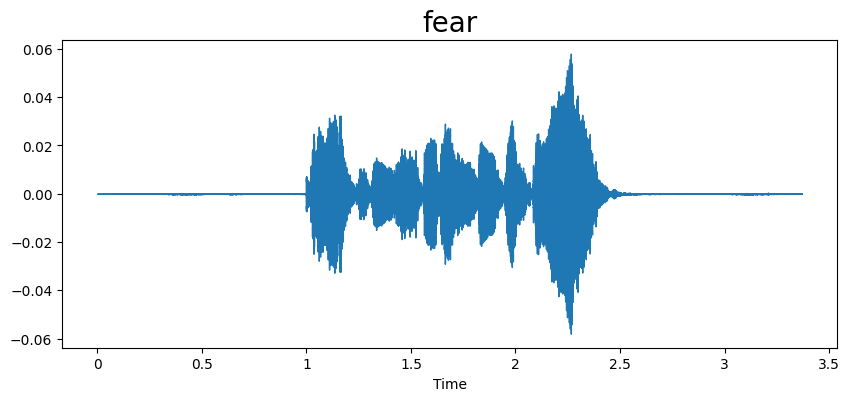

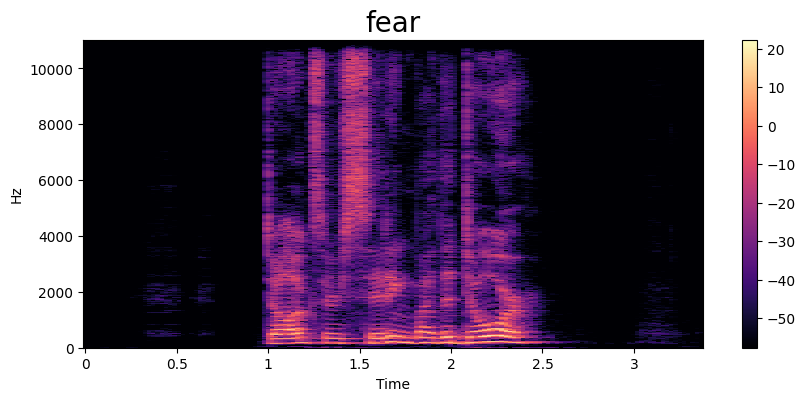

In [15]:
# Visualizing Fear Emotion
emotion = 'fear'
path = df[df["label"]=='fear'].iloc[0,0]
## convert audio to array
data, sampling_rate = librosa.load(path)
## waveplot
waveplot(data, sampling_rate, emotion)
## spectrogram
spectrogram(data, sampling_rate, emotion)
Audio(path)

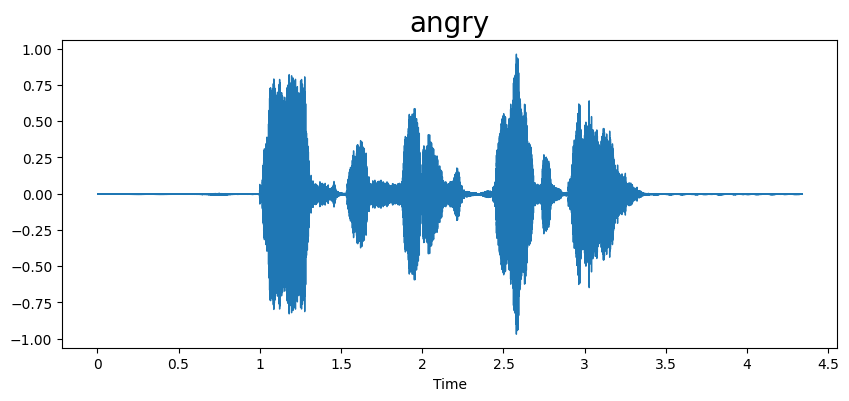

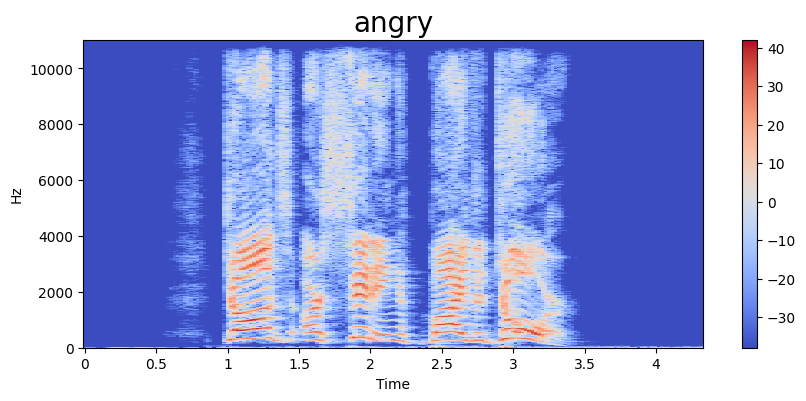

In [16]:
# Visualizing emotion angry
emotion = 'angry'
path = df[df["label"]==emotion].iloc[0,0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

In [17]:
# Function to extract audio
def feature_extraction(audio_path):
  # audio to array conversion
  x, sample_rate = librosa.load(audio_path)
  # feature extraction
  mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40).T, axis = 0)
  return mfccs

In [18]:
# features of 1st audio file
feature_extraction(df['speech'][0])

array([-6.4755029e+02,  7.2783432e+01,  1.2891841e+01,  1.6450842e+01,
        8.9649601e+00, -8.7523705e-01, -6.9449282e+00, -7.2962747e+00,
        4.6732965e+00, -5.8999701e+00, -1.5077101e+00,  1.1568080e+00,
        2.0812633e+00, -4.1671271e+00,  1.9336802e+00,  4.7913423e-01,
       -4.5923548e+00,  3.8016684e+00, -2.8300536e+00, -3.9559051e-01,
       -5.3217168e+00,  1.3168118e+00, -3.0403841e+00, -3.3648500e+00,
       -1.4430455e+00,  2.1542485e+00, -3.2994611e+00,  1.9140043e+00,
       -4.3359809e+00, -9.8880619e-01, -4.4954500e+00,  2.4559069e-01,
       -1.7157674e+00,  7.1927840e-01, -3.4124696e+00, -2.2462583e+00,
       -5.5530257e+00, -2.4406903e+00, -1.5551928e+00,  1.1611257e+00],
      dtype=float32)

In [19]:
# feature extraction of all the audio data
X_mfcc = df['speech'].apply(lambda x : feature_extraction(x))

In [20]:
X_mfcc

0       [-647.5503, 72.78343, 12.891841, 16.450842, 8....
1       [-366.46887, 27.860258, -17.687838, 7.012032, ...
2       [-596.57965, 55.796394, 1.6499813, 11.262543, ...
3       [-686.0836, 50.24728, 7.8531966, 13.398187, 4....
4       [-636.30176, 65.80612, 6.5092382, 12.24987, 6....
                              ...                        
4043    [-508.1401, 76.66571, 19.535923, 6.481646, 4.2...
4044    [-530.0818, 85.577866, 22.566677, 3.2036233, 1...
4045    [-496.1856, 48.013718, 17.239172, 7.6579437, 5...
4046    [-520.45953, 88.72616, 27.15327, -2.3303828, 1...
4047    [-522.0241, 81.624626, 28.421207, -3.8649015, ...
Name: speech, Length: 4048, dtype: object

In [21]:
# changing the shape of X_mfcc-extracted features
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(4048, 40)

In [22]:
X = np.expand_dims(X, -1)
X.shape

(4048, 40, 1)

In [23]:
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import np_utils

# le = LabelEncoder()
# y = np_utils.to_categorical(le.fit_transform(df['label']))

In [24]:
# One Hot Encoding to the labels
ohe = OneHotEncoder()
y = ohe.fit_transform(df[['label']])
y = y.toarray()

In [25]:
# labels after encoding
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [26]:
# dumping the OHE to future use
import pickle
pickle.dump(ohe,open('ohe.pkl','wb'))

In [27]:
y.shape

(4048, 7)

In [28]:
X.shape

(4048, 40, 1)

## **Model Creation**

In [39]:
# saving best val_accuracy model
checkpoint_filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath,monitor='val_accuracy',save_best_only=True,mode='max',verbose=1)

model = Sequential()
model.add(LSTM(256,return_sequences=False, input_shape=(40,1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(123, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

In [40]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 123)               31611     
                                                      

In [41]:
from keras.optimizers import Adam
# changing the learning rate - the model is overfitted, so to deal with this
initial_learning_rate = 0.001
optimizer = Adam(lr=initial_learning_rate)
# compiling model
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [42]:
# from keras.callbacks import EarlyStopping
# callback = EarlyStopping(patience=10, monitor="val_accuracy", mode="auto",verbose=1)

In [43]:
# traning the model
history = model.fit(X, y, batch_size=64, epochs=10, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 5.6822 - accuracy: 0.4858
Epoch 1: val_accuracy improved from -inf to 0.28395, saving model to best_model.h5
51/51 [==============================] - 15s 244ms/step - loss: 5.6822 - accuracy: 0.4858 - val_loss: 4.9947 - val_accuracy: 0.2840
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 3.8299 - accuracy: 0.6396
Epoch 2: val_accuracy improved from 0.28395 to 0.28889, saving model to best_model.h5
51/51 [==============================] - 11s 225ms/step - loss: 3.8299 - accuracy: 0.6396 - val_loss: 3.9945 - val_accuracy: 0.2889
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 2.7325 - accuracy: 0.6677
Epoch 3: val_accuracy improved from 0.28889 to 0.49012, saving model to best_model.h5
51/51 [==============================] - 12s 237ms/step - loss: 2.7325 - accuracy: 0.6677 - val_loss: 2.7934 - val_accuracy: 0.4901
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss:

### **After Training we reach upto 62%**

## **Streamlit application**

In [44]:
!pip install streamlit -q

In [45]:
# Creating app file
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm
from tensorflow.keras.models import load_model
import pickle

# Loading
model = load_model('best_model.h5')
ohe = pickle.load(open('ohe.pkl','rb'))

def feature_extraction(audio_path):
  x, sample_rate = librosa.load(audio_path)
  mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40).T, axis = 0)
  feature = mfccs.reshape(1,-1)
  return feature

# Saving the uploaded audio
def save_uploaded_file(uploaded_file):
  try:
    with open(os.path.join('uploads',uploaded_file.name),'wb') as f:
      f.write(uploaded_file.getbuffer())
    return 1
  except:
    return 0

classes = ohe.get_feature_names_out(['label'])
class_mapping = {i: class_name for i, class_name in enumerate(classes)}

st.title('Speech Emotion Classification')

uploaded_file = st.file_uploader("Choose an audio:")
if uploaded_file is not None:
  if save_uploaded_file(uploaded_file):
    audio_bytes = uploaded_file.read()
    st.audio(audio_bytes)

    feature = feature_extraction(os.path.join('uploads',uploaded_file.name))
    predicted_class = model.predict(feature).argmax(axis=1)[0]

    st.subheader("predicted Audio is: " + class_mapping[predicted_class].title())
  else:
    st.header("Some Error")

Overwriting app.py


In [46]:
!wget -q -O - ipv4.icanhazip.com

35.231.37.152


In [47]:
!streamlit run app.py & npx localtunnel --port 8501

[..................] / rollbackFailedOptional: verb npm-session 65f0997c0965d27


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.231.37.152:8501

npx: installed 22 in 5.193s
your url is: https://small-facts-argue.loca.lt
2023-08-25 07:36:14.766985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [==============================] - 1s 500ms/step
  Stopping...
^C
